bert ann

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [2]:
therapis_responses = pd.read_csv("data/Therapist_responses.csv",delimiter=",")
annotated_data = pd.read_csv("data/Annotated_data.csv",delimiter=",")
annotated_data_copy = pd.read_csv("data/Annotated_data.csv",delimiter=",")
merged_data = pd.merge(therapis_responses,annotated_data,on='Id_Number')

In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

def remove_stop_words(text):
    text = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word.isalpha() and not word in stop_words]
    return ' '.join(text)

texts = annotated_data_copy["Patient Question"].tolist()

sentences = list(map(remove_stop_words,texts))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RoscaMitrut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def label_distorsion_binary(row):
    if row["Dominant Distortion"] == "No Distortion":
        return 0
    return 1

annotated_data_copy["Distortion"] = annotated_data_copy.apply(label_distorsion_binary, axis=1)
annotated_data_copy = annotated_data_copy.drop(['Distorted part','Dominant Distortion','Secondary Distortion (Optional)'],axis=1)

In [5]:
distortions = annotated_data_copy["Distortion"].tolist()

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(sentences, distortions)

In [7]:
preprocess_link = "https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3"
encoder_link = "https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-l-12-h-768-a-12/4"

preprocessor = hub.KerasLayer(preprocess_link)
encoder = hub.KerasLayer(encoder_link)

In [8]:
def get_embedings_sentences(sentences):
	preprocessed_text = preprocessor(sentences)
	return encoder(preprocessed_text)["pooled_output"]
	#return encoder(preprocessed_text)["sequence_output"]
 
get_embedings_sentences(["Hello fellow humans!"]) 

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-0.7502277 , -0.13671456,  0.34805366,  0.45483565, -0.32820255,
         0.00750104,  0.82495487,  0.08206423,  0.22131631, -0.9988444 ,
         0.26265964,  0.08342557,  0.9605094 , -0.07627685,  0.8965189 ,
        -0.4565765 , -0.08621861, -0.4226598 ,  0.24628411, -0.5744989 ,
         0.44919172,  0.8881553 ,  0.55336344,  0.15241079,  0.20557725,
         0.17250198, -0.52908266,  0.89130056,  0.9129521 ,  0.5484023 ,
        -0.5697616 ,  0.04072607, -0.96261215, -0.10015959,  0.3376387 ,
        -0.9447048 ,  0.00531326, -0.6605004 ,  0.08838216,  0.10863174,
        -0.8132668 ,  0.10283432,  0.9858325 , -0.37569004, -0.1333966 ,
        -0.28062207, -0.9987455 ,  0.13708162, -0.76875407, -0.4452786 ,
        -0.1691201 , -0.5963505 ,  0.01558585,  0.23921967,  0.27617282,
         0.46880317, -0.22998405, -0.00318363, -0.00855811, -0.3808298 ,
        -0.5191878 ,  0.15526955,  0.00151621, -0.8110866 , -0.09670857,
 

In [9]:

#BERT
text_input = tf.keras.layers.Input(shape=(),dtype=tf.string,name="text")
preprocessed_text = preprocessor(text_input)
outputs = encoder(preprocessed_text)
#NN
#layer = tf.keras.layers.Dense(10,activation="relu")(outputs["pooled_output"])
#layer = tf.keras.layers.Dropout(0.25,name="dropout")(layer)
#layer = tf.keras.layers.Dense(1,activation="sigmoid",name="output")(layer)

layer = tf.keras.layers.Dropout(0.05,name="dropout")(outputs["pooled_output"])
layer = tf.keras.layers.Dense(1,activation="sigmoid",name="output")(layer)

#Model
model = tf.keras.Model(inputs=[text_input],outputs=[layer])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [10]:
METRICS = [
	tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=METRICS)

In [11]:
#history = model.fit(X_train,Y_train,epochs=25)
history = model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=5)


Epoch 1/5
60/60 [==============================] - 58s 684ms/step - loss: 0.6448 - accuracy: 0.6310 - precision: 0.6486 - recall: 0.9019 - val_loss: 0.6343 - val_accuracy: 0.6382 - val_precision: 0.6427 - val_recall: 0.9752
Epoch 2/5
60/60 [==============================] - 39s 648ms/step - loss: 0.6347 - accuracy: 0.6431 - precision: 0.6621 - recall: 0.8835 - val_loss: 0.6208 - val_accuracy: 0.6524 - val_precision: 0.6581 - val_recall: 0.9480
Epoch 3/5
60/60 [==============================] - 39s 657ms/step - loss: 0.6178 - accuracy: 0.6563 - precision: 0.6709 - recall: 0.8902 - val_loss: 0.6169 - val_accuracy: 0.6461 - val_precision: 0.6500 - val_recall: 0.9653
Epoch 4/5
60/60 [==============================] - 40s 661ms/step - loss: 0.6314 - accuracy: 0.6568 - precision: 0.6771 - recall: 0.8684 - val_loss: 0.6185 - val_accuracy: 0.6430 - val_precision: 0.6454 - val_recall: 0.9777
Epoch 5/5
60/60 [==============================] - 45s 748ms/step - loss: 0.6106 - accuracy: 0.6637 - pr

[]

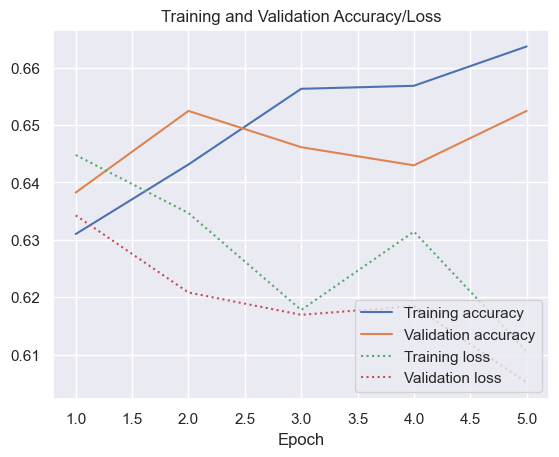

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
 
acc = history.history['accuracy']
val = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, '-', label='Validation accuracy')
plt.plot(epochs,loss,':',label="Training loss")
plt.plot(epochs,val_loss,':',label="Validation loss")
plt.title('Training and Validation Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.plot()

In [13]:
model.evaluate(X_test,Y_test)

20/20 [==============================] - 12s 592ms/step - loss: 0.6051 - accuracy: 0.6524 - precision: 0.6736 - recall: 0.8837


[0.6051443219184875,
 0.6524486541748047,
 0.6735848784446716,
 0.8836633563041687]

20/20 [==============================] - 13s 590ms/step


Text(47.25, 0.5, 'Truth')

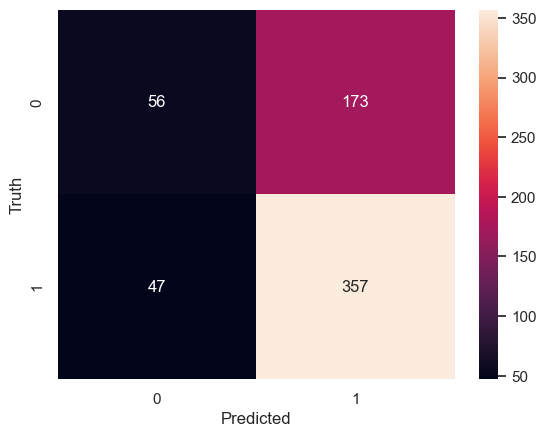

In [14]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5,1,0)
cm = confusion_matrix(Y_test, y_predicted)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')